In [1]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath('..'))
import torch
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets, VBox, HBox
import numpy as np
from torch.utils.data import DataLoader, random_split
import random
from src.dataset import ProjectDatasets
from src.models.unet import UNet
from src.utils.helpers import visualize_batch_with_colorbar
from torchvision.transforms import Compose, ToTensor, Normalize
from src.utils.mapping import maskToClassIndex,classIndexToMask

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
#checkpoints_path = "/net/travail/rramesh/AdvanceimageProcessing/Semantic-Segmentation-for-Autonomous-Driving/experiments/checkpoint_epoch_10.pth"
checkpoints_path = "/net/cremi/sasifchaudhr/espaces/travail/Semantic-Segmentation-for-Autonomous-Driving/experiments/experiment_20241230-093214/checkpoints/best_model.pth"

transform = Compose([ToTensor(), Normalize(mean=[0.5], std=[0.5])])
dataset = ProjectDatasets(root_path="/net/ens/am4ip/datasets/project-dataset", transform=transform)
sample = dataset[0]  # Should return 4 values
print(len(sample))  # Should print 4

model = UNet(in_channels=3, out_channels=31)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Pre-warm CUDA
if torch.cuda.is_available():
    _ = torch.randn(1).to(device)

checkpoint = torch.load(checkpoints_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])


4


/tmp/cache-sasifchaudhr/ipykernel_1830219/67645064.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoints_path, map_location=device)


<All keys matched successfully>

In [3]:
# Split dataset
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
generator = torch.Generator().manual_seed(seed)
_, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

In [4]:
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [5]:
# for batch_idx, (inputs, targets, _) in enumerate(val_loader):
#     with torch.no_grad():
#         inputs, targets = inputs.to(device), targets.to(device)
#         predictions = model(inputs)
#         predictions = torch.argmax(predictions, dim=1)  # Assuming output is logits
        
#         print(f"The shape of the prediction is {predictions.shape}")  
#        # Check intensity range of predictions
#         max_intensity = torch.max(predictions).item()
#         min_intensity = torch.min(predictions).item()
#         print(f"The maximum intensity of the prediction is {max_intensity} and the minimum is {min_intensity}")
        
#     visualize_batch_with_colorbar(inputs, predictions, targets, batch_idx, num_samples=3)
#     break# Visualize only the first batch

# Mapping RGB pixel in prediction

the shape of the targets is torch.Size([16, 256, 256])
the shape of the inputs is torch.Size([16, 3, 256, 256])
the shape of the prediction is torch.Size([16, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


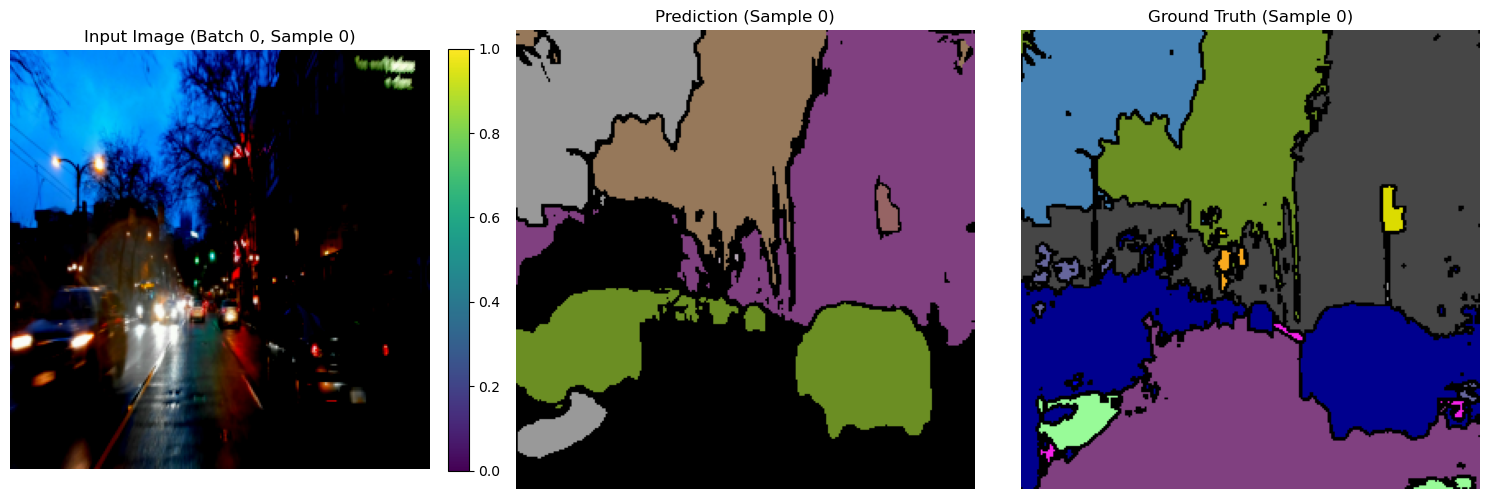

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


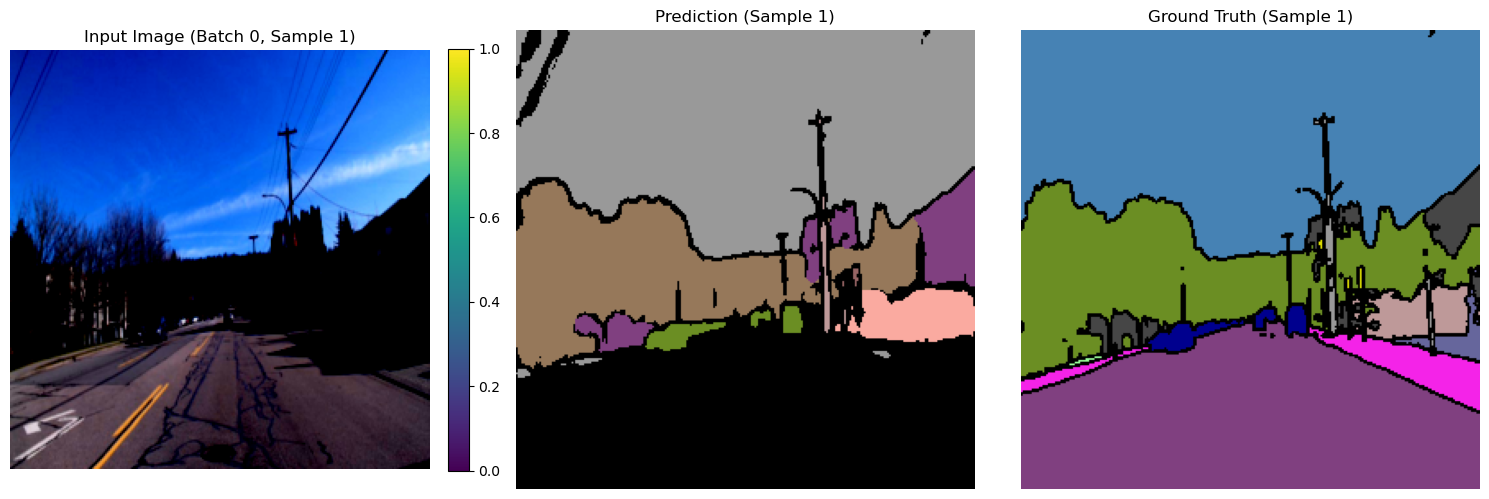

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


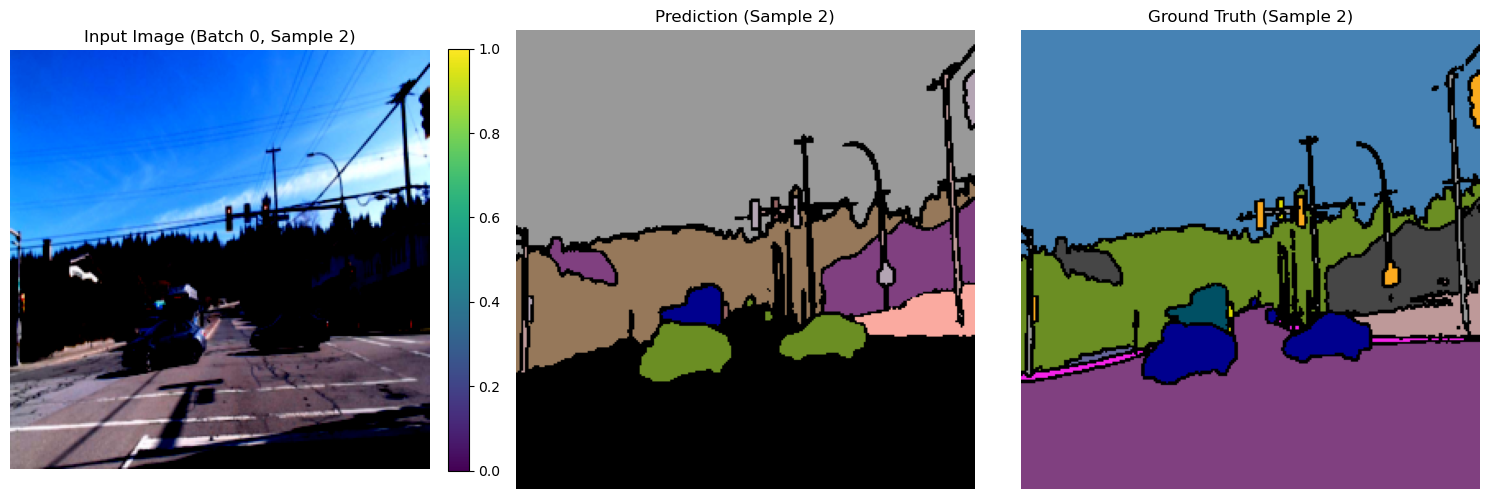

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


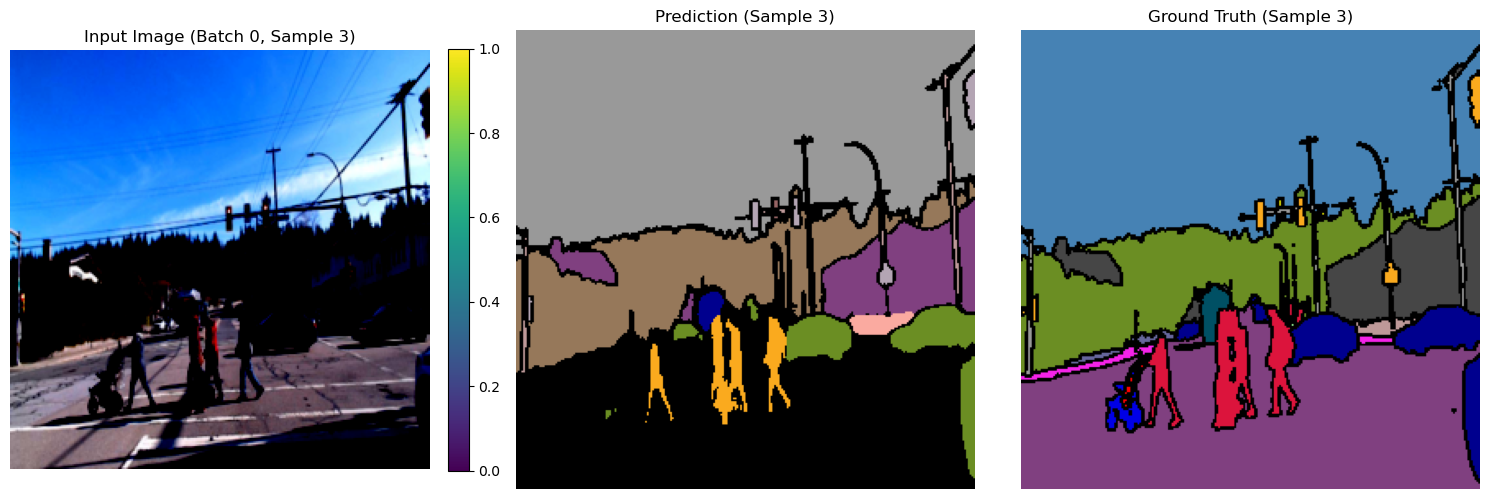

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


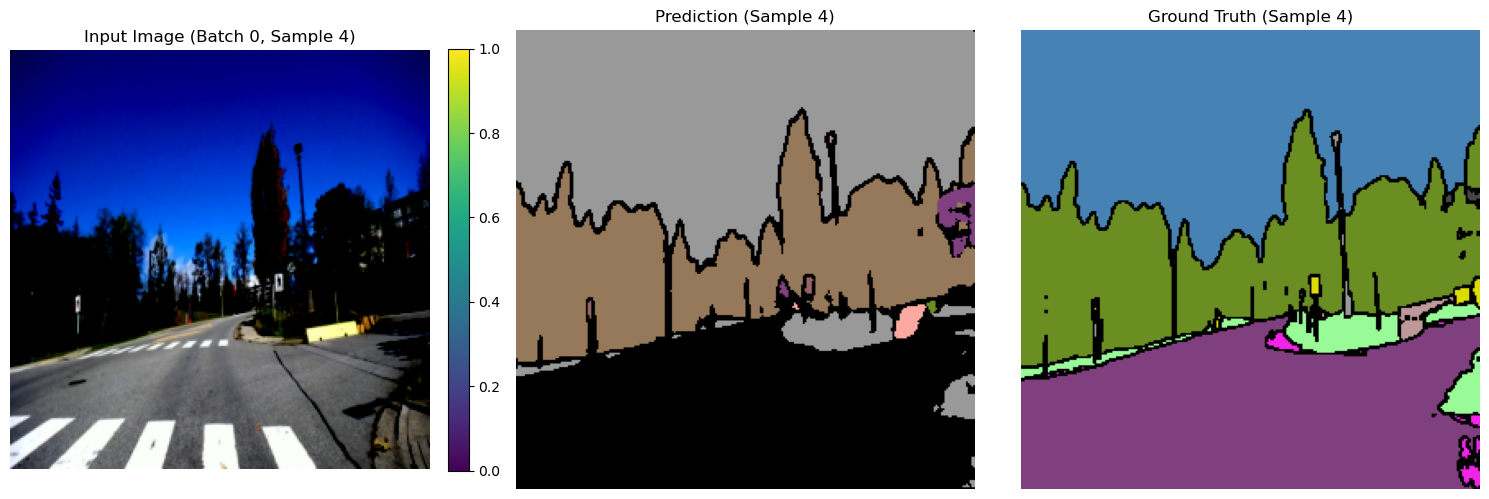

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


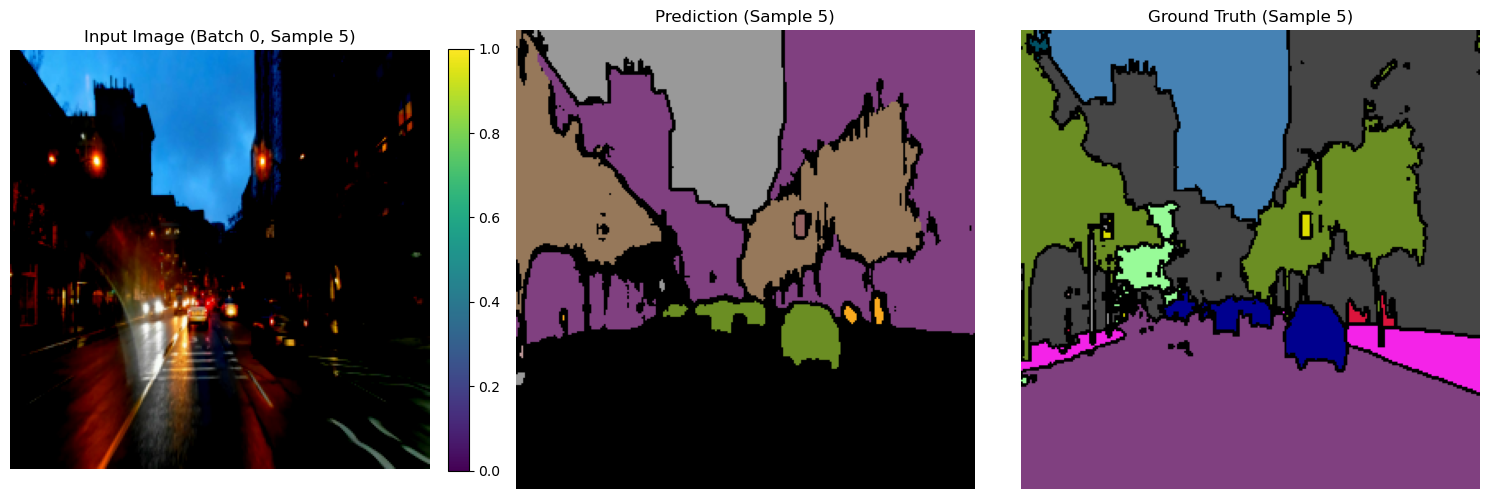

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


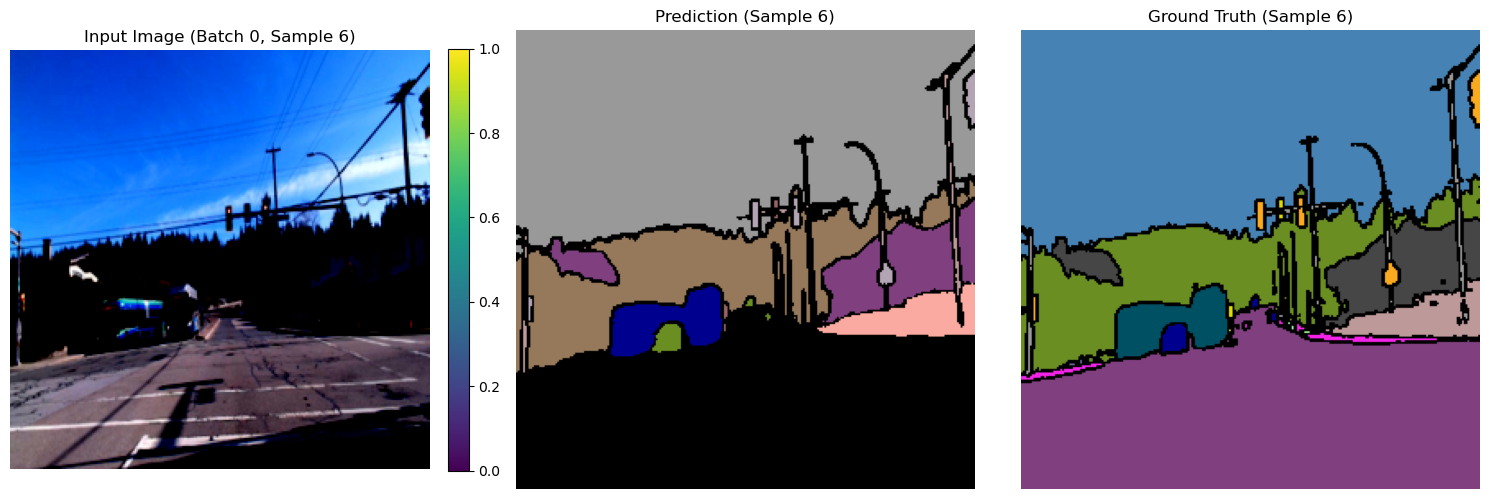

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


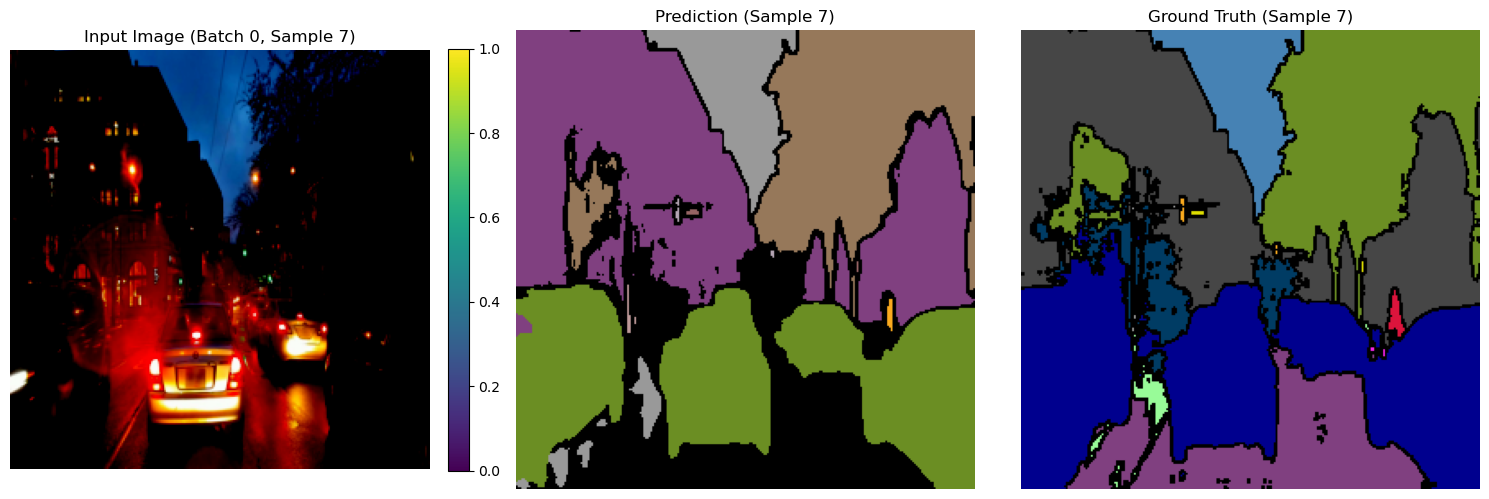

In [9]:
# # Example: Visualizing predictions
for batch_idx, (inputs, targets, _,_) in enumerate(val_loader):
    with torch.no_grad():
        inputs, targets = inputs.to(device), targets.to(device)
        predictions = model(inputs)
        predictions = torch.argmax(predictions, dim=1)  # Shape: [N, H, W]

        print(f"the shape of the targets is {targets.shape}")
        print(f"the shape of the inputs is {inputs.shape}")
        print(f"the shape of the prediction is {predictions.shape}")
        
        # Convert all predictions in the batch to RGB format
        rgb_predictions = np.stack([
            classIndexToMask(predictions[i].cpu().numpy()) for i in range(predictions.shape[0])
        ])  # Shape: [N, H, W, 3]
        

        rgb_targets = np.stack([
            classIndexToMask(targets[i].cpu().numpy()) for i in range(targets.shape[0])
        ])


    # Visualize the batch with RGB predictions
    visualize_batch_with_colorbar(inputs, rgb_predictions, rgb_targets, batch_idx, num_samples=8, rgb_pred=True)
    break



## Working Welll


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import ipywidgets as widgets
from IPython.display import display, clear_output
import time

class VideoPlayer:
    def __init__(self, inputs, predictions, targets, sources, image_names, rgb_pred=False, interval=0.5):
        """
        Initialize the VideoPlayer for interactive visualization.
        """
        self.inputs = inputs.cpu().numpy()
        self.predictions = predictions
        self.targets = targets if isinstance(targets, np.ndarray) else targets.cpu().numpy()
        self.sources = sources
        self.image_names = image_names
        self.rgb_pred = rgb_pred
        self.num_samples = inputs.shape[0]
        self.interval = interval  # Playback speed in seconds

        # Normalize inputs, predictions, and targets once
        self.normalized_inputs = (self.inputs.transpose(0, 2, 3, 1) + 1) / 2  # CHW to HWC and scale to [0, 1]
        self.normalized_predictions = (
            self.predictions / 255.0 if self.predictions.max() > 1 else self.predictions
        )
        self.normalized_targets = (
            self.targets / 255.0 if self.targets.max() > 1 else self.targets
        )

        # State variables
        self.current_index = 0
        self.playing = False

        # Widgets
        self.slider = widgets.IntSlider(value=0, min=0, max=self.num_samples - 1, step=1, description="Frame:")
        self.play_button = widgets.ToggleButton(value=False, description="Play", button_style="success")
        self.next_button = widgets.Button(description="Next")
        self.prev_button = widgets.Button(description="Previous")
        self.output = widgets.Output()

        # Event bindings
        self.play_button.observe(self.toggle_play, names="value")
        self.slider.observe(self.update_frame, names="value")
        self.next_button.on_click(self.next_frame)
        self.prev_button.on_click(self.previous_frame)

        # Layout
        self.controls = widgets.HBox([self.prev_button, self.play_button, self.next_button, self.slider])
        display(self.controls, self.output)

    def display_frame(self, index):
        """
        Display the frame corresponding to the given index.
        """
        with self.output:
            # Clear the output widget
            clear_output(wait=True)

            # Create a new figure for the current frame
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            # Input image
            axes[0].imshow(self.normalized_inputs[index], vmin=0, vmax=1)
            axes[0].set_title(f"Input Image (Frame {index})", fontsize=12)
            axes[0].axis("off")

            # Prediction
            if self.rgb_pred:
                axes[1].imshow(self.normalized_predictions[index], vmin=0, vmax=1)
            else:
                axes[1].imshow(self.normalized_predictions[index], cmap="gray", vmin=0, vmax=1)
            axes[1].set_title(f"Prediction (Frame {index})", fontsize=12)
            axes[1].axis("off")

            # Ground truth
            axes[2].imshow(self.normalized_targets[index], vmin=0, vmax=1)
            axes[2].set_title(f"Ground Truth (Frame {index})", fontsize=12)
            axes[2].axis("off")

            # Add source and image name
            fig.suptitle(
                f"Source: {self.sources[index]} | Image Name: {self.image_names[index]}",
                fontsize=14,
                y=0.98,
            )

            # Adjust layout and show
            plt.tight_layout()
            plt.show()

    def toggle_play(self, change):
        """
        Toggle play/pause functionality.
        """
        self.playing = change["new"]
        if self.playing:
            self.play_button.description = "Pause"
            self.play_button.button_style = "danger"
            self.start_playback()
        else:
            self.play_button.description = "Play"
            self.play_button.button_style = "success"

    def start_playback(self):
        """
        Start playback in a loop until stopped or frames exhausted.
        """
        while self.playing and self.current_index < self.num_samples:
            self.display_frame(self.current_index)
            self.slider.value = self.current_index
            time.sleep(self.interval)  # Pause for the specified interval
            self.current_index += 1
            if self.current_index >= self.num_samples:
                self.playing = False
                self.play_button.value = False
                self.play_button.description = "Play"
                self.play_button.button_style = "success"

    def update_frame(self, change):
        """
        Update the displayed frame when the slider is adjusted.
        """
        self.current_index = change["new"]
        self.display_frame(self.current_index)

    def next_frame(self, _):
        """
        Display the next frame.
        """
        if self.current_index < self.num_samples - 1:
            self.current_index += 1
            self.slider.value = self.current_index
            self.display_frame(self.current_index)

    def previous_frame(self, _):
        """
        Display the previous frame.
        """
        if self.current_index > 0:
            self.current_index -= 1
            self.slider.value = self.current_index
            self.display_frame(self.current_index)


In [ ]:
# Initialize containers for all batches
all_inputs = []
all_predictions = []
all_targets = []
all_sources = []
all_image_names = []

# Process each batch
for batch_idx, (inputs, targets, sources, image_names) in enumerate(val_loader):
    with torch.no_grad():
        inputs, targets = inputs.to(device), targets.to(device)
        predictions = model(inputs)
        predictions = torch.argmax(predictions, dim=1)  # Shape: [N, H, W]

        # Convert predictions and targets to RGB
        rgb_predictions = np.stack([
            classIndexToMask(predictions[i].cpu().numpy()) for i in range(predictions.shape[0])
        ])  # Shape: [N, H, W, 3]

        rgb_targets = np.stack([
            classIndexToMask(targets[i].cpu().numpy()) for i in range(targets.shape[0])
        ])

        # Collect results for all batches
        all_inputs.append(inputs.cpu())
        all_predictions.append(rgb_predictions)
        all_targets.append(rgb_targets)
        all_sources.extend(sources)  # Assuming sources is a list of strings
        all_image_names.extend(image_names)  # Assuming image_names is a list of strings
        break

# Concatenate all collected tensors and arrays
all_inputs = torch.cat(all_inputs, dim=0)  # Concatenate inputs along the batch dimension
all_predictions = np.concatenate(all_predictions, axis=0)  # Concatenate predictions along the batch dimension
all_targets = np.concatenate(all_targets, axis=0)  # Concatenate targets along the batch dimension

# Pass the combined data to the VideoPlayer
VideoPlayer(all_inputs, all_predictions, all_targets, all_sources, all_image_names, rgb_pred=True)

Output()

: 